In [2]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 8.8 MB/s eta 0:00:00 0:00:01m
Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import timedelta

# Load datasets
average_data = pd.read_csv("/Users/erolberkiyibozkurt/Documents/GitHub/Python/Projects/The Influence of AI Boom on Tech Stocks/Extracted Data/stock_timeseries_usd_full.csv")
ai_events = pd.read_csv("/Users/erolberkiyibozkurt/Documents/GitHub/Python/Projects/The Influence of AI Boom on Tech Stocks/Background Data/timeline_of_the_ai.csv")

# Ensure date columns are in datetime format
average_data['Date'] = pd.to_datetime(average_data['Date'], errors='coerce')
ai_events['Date'] = pd.to_datetime(ai_events['Date'], errors='coerce')

# Rename columns to match the dataset
average_data.rename(columns={
    'Adj Close': 'Adj_Close',
    'Close': 'Close_Price',
    'High': 'High_Price',
    'Low': 'Low_Price',
    'Open': 'Open_Price'
}, inplace=True)

# Filter average data for dates after the earliest AI event
earliest_event_date = ai_events['Date'].min()
filtered_average_data = average_data[average_data['Date'] >= earliest_event_date]

# Initialize a list to store regression results
regression_results = []

for event in ai_events['AI Event'].unique():
    # Filter data around the event
    event_date = ai_events.loc[ai_events['AI Event'] == event, 'Date'].iloc[0]
    event_window = filtered_average_data[
        (filtered_average_data['Date'] >= (event_date - timedelta(days=7))) &
        (filtered_average_data['Date'] <= (event_date + timedelta(days=7)))
    ]
    
    # Skip if event_window is empty
    if event_window.empty:
        continue
    
    # Prepare data for regression
    event_window['AI_Event_Impact'] = (event_window['Date'] == event_date).astype(int)
    event_window['Constant'] = 1  # Add constant term
    X = event_window[['Constant', 'AI_Event_Impact']]
    y = event_window['Adj_Close']
    
    # Perform regression
    model = sm.OLS(y, X).fit()
    regression_results.append((event, model.rsquared, event_window, model))

# Sort regression results by R-squared to find the most and least impactful events
sorted_results = sorted(regression_results, key=lambda x: x[1], reverse=True)
most_impactful = sorted_results[:4]
least_impactful = sorted_results[-4:]

# Plot and save graphs for each impactful event
for i, (event, _, data, model) in enumerate(most_impactful):
    plt.figure(figsize=(8, 6))
    plt.scatter(data['AI_Event_Impact'], data['Adj_Close'], alpha=0.6, label='Data Points')
    plt.plot(data['AI_Event_Impact'], model.predict(), color='red', label='Regression Line')
    plt.title(f"Most Impactful Event {i+1}: {event} (R² = {model.rsquared:.3f})")
    plt.xlabel("AI Event Impact")
    plt.ylabel("Average Adj Close Price")
    plt.legend()
    plt.savefig(f"most_impactful_event_{i+1}.png")
    plt.close()

for i, (event, _, data, model) in enumerate(least_impactful):
    plt.figure(figsize=(8, 6))
    plt.scatter(data['AI_Event_Impact'], data['Adj_Close'], alpha=0.6, label='Data Points')
    plt.plot(data['AI_Event_Impact'], model.predict(), color='red', label='Regression Line')
    plt.title(f"Least Impactful Event {i+1}: {event} (R² = {model.rsquared:.3f})")
    plt.xlabel("AI Event Impact")
    plt.ylabel("Average Adj Close Price")
    plt.legend()
    plt.savefig(f"least_impactful_event_{i+1}.png")
    plt.close()

# Correlation analysis
correlation = filtered_average_data['Adj_Close'].corr(filtered_average_data['Date'].astype(int))
print(f"Correlation between Adj Close and Date: {correlation}")


/var/folders/g1/lmg3w4rs5t7f4c_vswsjfrz80000gn/T/ipykernel_86514/1088415570.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_window['AI_Event_Impact'] = (event_window['Date'] == event_date).astype(int)
/var/folders/g1/lmg3w4rs5t7f4c_vswsjfrz80000gn/T/ipykernel_86514/1088415570.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_window['Constant'] = 1  # Add constant term
/var/folders/g1/lmg3w4rs5t7f4c_vswsjfrz80000gn/T/ipykernel_86514/1088415570.py:43: SettingWithCopyWarning: 
A value is tr

Correlation between Adj Close and Date: 0.10219974919309975


In [10]:
import pandas as pd
import statsmodels.api as sm

# Load the MWE dataset
mwe_data_path = "/Users/erolberkiyibozkurt/Documents/GitHub/Python/Projects/The Influence of AI Boom on Tech Stocks/Extracted Data/mwe_table_for_ai_events.csv"  # Update with your actual file path
mwe_data = pd.read_csv(mwe_data_path)

# Clean the data: Remove rows with NaN or Inf values
mwe_data = mwe_data.dropna()
mwe_data = mwe_data[~mwe_data.isin([float('inf'), float('-inf')]).any(axis=1)]

# Define independent variables (Pre-Event Avg, Pre-to-Event Change (%), Event-to-Post Change (%))
X = mwe_data[["Pre-Event Avg", "Pre-to-Event Change (%)", "Event-to-Post Change (%)"]]

# Define dependent variable (Post-Event Avg)
y = mwe_data["Post-Event Avg"]

# Add a constant to the independent variables (for the intercept in regression)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Display the summary of the regression results
print("Regression Results for AI Events:\n")
print(model.summary())

# Select only numeric columns for correlation matrix
numeric_columns = mwe_data.select_dtypes(include=['float64', 'int64'])

# Correlation Matrix
correlation_matrix = numeric_columns.corr()
print("\nCorrelation Matrix:\n")
print(correlation_matrix)


Regression Results for AI Events:

                            OLS Regression Results                            
Dep. Variable:         Post-Event Avg   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     9791.
Date:                Sat, 18 Jan 2025   Prob (F-statistic):           3.20e-51
Time:                        19:18:49   Log-Likelihood:                -70.079
No. Observations:                  39   AIC:                             148.2
Df Residuals:                      35   BIC:                             154.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

Regression Results for AI Events:

                            OLS Regression Results                            
Dep. Variable:         Post-Event Avg   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     946.9
Date:                Sat, 18 Jan 2025   Prob (F-statistic):           5.82e-28
Time:                        19:27:56   Log-Likelihood:                -137.41
No. Observations:                  39   AIC:                             278.8
Df Residuals:                      37   BIC:                             282.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const      

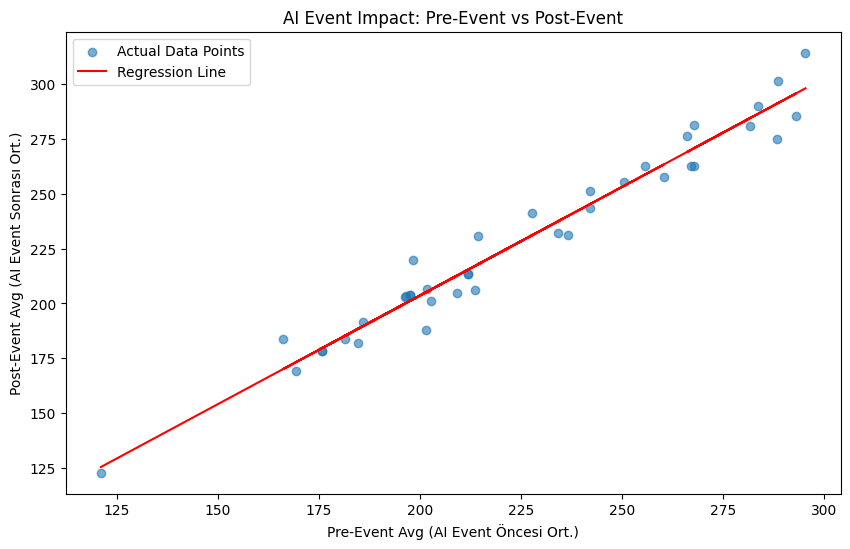


Average Change (%): 1.56%
Stock prices tend to increase after AI events.


In [12]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the MWE dataset
mwe_data_path = "/Users/erolberkiyibozkurt/Documents/GitHub/Python/Projects/The Influence of AI Boom on Tech Stocks/Extracted Data/mwe_table_for_ai_events.csv"  # Update with your actual file path
mwe_data = pd.read_csv(mwe_data_path)

# Clean the data: Remove rows with NaN or Inf values
mwe_data = mwe_data.dropna()
mwe_data = mwe_data[~mwe_data.isin([float('inf'), float('-inf')]).any(axis=1)]

# Define independent variable (Pre-Event Avg)
X = mwe_data[["Pre-Event Avg"]]

# Define dependent variable (Post-Event Avg)
y = mwe_data["Post-Event Avg"]

# Add a constant to the independent variables (intercept)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Display the summary of the regression results
print("Regression Results for AI Events:\n")
print(model.summary())

# Scatter plot of Pre-Event vs Post-Event
plt.figure(figsize=(10, 6))
plt.scatter(mwe_data["Pre-Event Avg"], mwe_data["Post-Event Avg"], alpha=0.6, label="Actual Data Points")
plt.plot(mwe_data["Pre-Event Avg"], model.predict(X), color='red', label="Regression Line")
plt.title("AI Event Impact: Pre-Event vs Post-Event")
plt.xlabel("Pre-Event Avg (AI Event Öncesi Ort.)")
plt.ylabel("Post-Event Avg (AI Event Sonrası Ort.)")
plt.legend()
plt.show()

# Check for overall change: Post-Event > Pre-Event
mwe_data["Change (%)"] = ((mwe_data["Post-Event Avg"] - mwe_data["Pre-Event Avg"]) / mwe_data["Pre-Event Avg"]) * 100
average_change = mwe_data["Change (%)"].mean()

print(f"\nAverage Change (%): {average_change:.2f}%")
if average_change > 0:
    print("Stock prices tend to increase after AI events.")
else:
    print("Stock prices tend to decrease after AI events.")
